In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Descrizione problema
Il dataset in esame riguarda analisi effettuate sull'acqua marina con decine di proprietà rilevate, noi prenderemo in considerazione solo la temperatura dell'acqua, la sua salinità e la sua profondità.
L'obiettivo del progetto è quello di trovare una relazione tra la temperatura dell'acqua e le altre due informazioni disponibili per poi predire il valore della temperatura.

In [56]:
def conf_interval(a, N, Z=1.96):
    c = (2 * N * a + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*a - 4*N*a**2) / (2 * (N + Z**2))
    return c - d, c + d

In [57]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

In [58]:
def model_conf_interval(model, X, y, level=0.95):
    a = model.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return conf_interval(a, N, Z)

In [59]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [60]:
def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5%}".format(r2_score(y, preds)))

In [61]:
def plot_model_on_data(X, y, eticX, eticY, model=None):
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 100)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel(eticX)
    plt.ylabel(eticY)

In [62]:
oceans = pd.read_csv("bottle.csv", low_memory=False)

# Data Exploration

In [63]:
oceans.head()

Cst_Cnt  Btl_Cnt       Sta_ID                                Depth_ID  \
0        1        1  054.0 056.0  19-4903CR-HY-060-0930-05400560-0000A-3   
1        1        2  054.0 056.0  19-4903CR-HY-060-0930-05400560-0008A-3   
2        1        3  054.0 056.0  19-4903CR-HY-060-0930-05400560-0010A-7   
3        1        4  054.0 056.0  19-4903CR-HY-060-0930-05400560-0019A-3   
4        1        5  054.0 056.0  19-4903CR-HY-060-0930-05400560-0020A-7   

   Depthm  T_degC  Salnty  O2ml_L  STheta  O2Sat  ...  R_PHAEO  R_PRES  \
0       0   10.50  33.440     NaN  25.649    NaN  ...      NaN       0   
1       8   10.46  33.440     NaN  25.656    NaN  ...      NaN       8   
2      10   10.46  33.437     NaN  25.654    NaN  ...      NaN      10   
3      19   10.45  33.420     NaN  25.643    NaN  ...      NaN      19   
4      20   10.45  33.421     NaN  25.643    NaN  ...      NaN      20   

   R_SAMP  DIC1  DIC2  TA1  TA2  pH2  pH1  DIC Quality Comment  
0     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
1     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
2     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
3     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  
4     NaN   NaN   NaN  NaN  NaN  NaN  NaN                  NaN  

[5 rows x 74 columns]

In [64]:
oceans.columns

Index(['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depth_ID', 'Depthm', 'T_degC',
       'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum',
       'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual',
       'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM',
       'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM',
       'NH3q', 'C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q',
       'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim',
       'LightP', 'R_Depth', 'R_TEMP', 'R_POTEMP', 'R_SALINITY', 'R_SIGMA',
       'R_SVA', 'R_DYNHT', 'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4', 'R_NO3',
       'R_NO2', 'R_NH4', 'R_CHLA', 'R_PHAEO', 'R_PRES', 'R_SAMP', 'DIC1',
       'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment'],
      dtype='object')

Il dataset è enorme e comprende 74 colonne, molte di esse non sono nemmeno riempite con dati.
Prendiamo le 3 colonne che ci interessano e le salviamo in un nuovo dataframe.

__Depthm__: che rappresenta la profondità in metri

__T_degX__: la temperatura in gradi Celsius

__Salnty__: la salinità rilevata in g/kg


In [65]:
data = oceans[["Salnty", "T_degC", "Depthm"]]

In [66]:
data.head()

Salnty  T_degC  Depthm
0  33.440   10.50       0
1  33.440   10.46       8
2  33.437   10.46      10
3  33.420   10.45      19
4  33.421   10.45      20

In [67]:
data.describe()

Salnty         T_degC         Depthm
count  817509.000000  853900.000000  864863.000000
mean       33.840350      10.799677     226.831951
std         0.461843       4.243825     316.050259
min        28.431000       1.440000       0.000000
25%        33.488000       7.680000      46.000000
50%        33.863000      10.060000     125.000000
75%        34.196900      13.880000     300.000000
max        37.034000      31.140000    5351.000000

Nella descrizione di queste proprietà supponiamo dei valori nulli basandoci sui diversi valori totali delle singole colonne.
Vediamo che i valori medi di ogni colonna sono in linea con i valori minimi e massimi, non occorre quindi gestire casi di misure sbagliate.

In [68]:
data.isna().sum()

Salnty    47354
T_degC    10963
Depthm        0
dtype: int64

Come pensavamo ci sono oltre 47 mila valori nulli nella Salinità e 10 mila nella Temperatura.
Per gestire questi casi ricorriamo al riempimento di questi valori tramite la media sul dataset.

In [69]:
data = data.fillna(data.mean())
data.isna().sum()

Salnty    0
T_degC    0
Depthm    0
dtype: int64

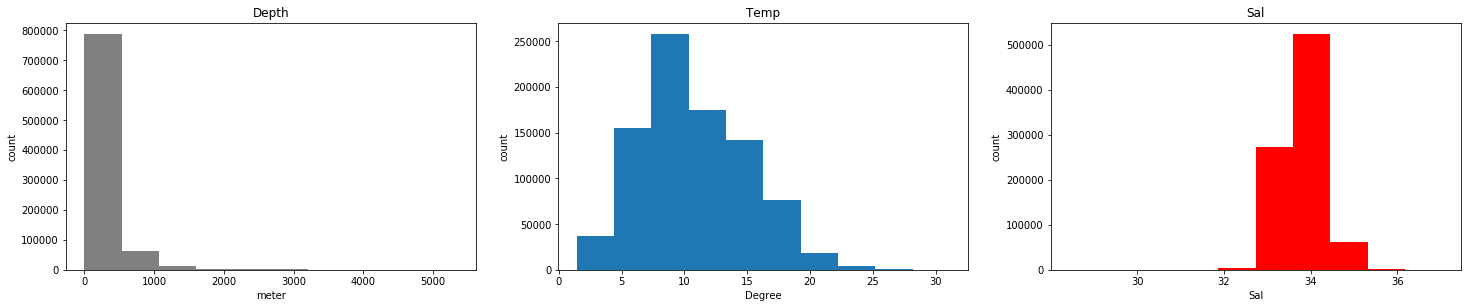

In [70]:
plt.figure(figsize=(25, 10))

plt.subplot(2, 3, 1)
plt.title('Depth')
plt.hist(data["Depthm"], color='gray')
plt.ylabel('count')
plt.xlabel('meter')

plt.subplot(2, 3, 2)
plt.title('Temp')
plt.hist(data["T_degC"])
plt.ylabel('count')
plt.xlabel('Degree')

plt.subplot(2, 3, 3)
plt.title('Sal')
plt.hist(data["Salnty"], color="red")
plt.ylabel('count')
plt.xlabel('Sal');

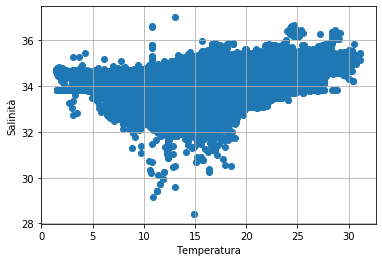

In [99]:
plot_model_on_data(data["T_degC"], data["Salnty"], "Temperatura", "Salinità")

Guardando il grafico risulta chiaro come non esista una vera corrispondenza tra la salinità e la temperatura dell'acqua

# Verificare se la profondità influenza la temperatura

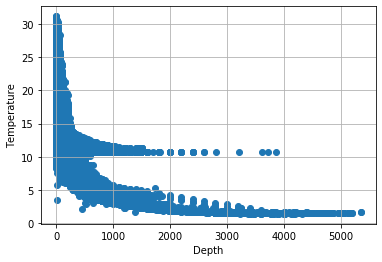

In [72]:
plot_model_on_data(data["Depthm"], data["T_degC"], "Depth", "Temperature")

Si vede un intervallo dove abbiamo 2 valori di temperature diversi, è probabile che sia dovuto al clima esterno che influenza la tempratura dell'acqua o al fatto che queste 2 misure siano fatte in luoghi diversi (ad esempio verso i poli e nell'equatore) dove le correnti mitigano l'acqua.
Si decide di eliminare i dati meno numerosi per uniformare meglio la curva.

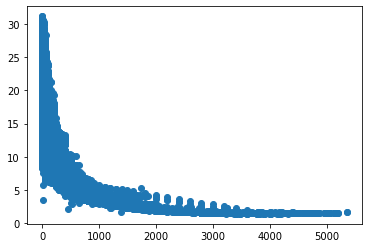

In [101]:
tmp = data[(data["Depthm"] > 400) & (data["T_degC"] > 10.5)]
plt.scatter(data["Depthm"], data["T_degC"])
plt.scatter(tmp["Depthm"], tmp["T_degC"], c="r")

In [74]:
data = data[(data["Depthm"] <= 400) | (data["T_degC"] <= 10.5)]

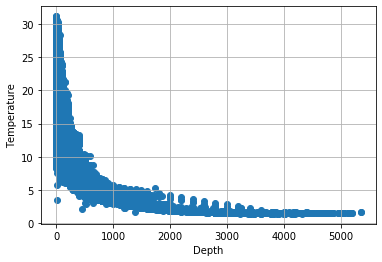

In [75]:
plot_model_on_data(data["Depthm"], data["T_degC"], "Depth", "Temperature")

In [76]:
X = data.iloc[:, 2:].values
y = data.iloc[:, -2].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.30)

Utilizziamo l'approccio di divisione in training set e validation set utilizzando il 70% del dataset come training e il restante 30% come validation

# Regressione lineare

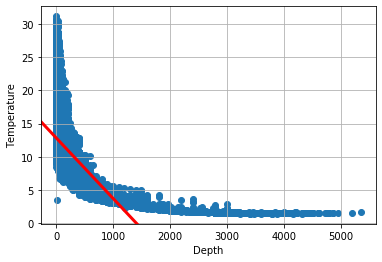

In [77]:
lin = Pipeline([
    ("poly",   PolynomialFeatures(degree=1, include_bias=False)),
    ("linreg", LinearRegression())
])
lin.fit(X_train, y_train)
plot_model_on_data(X_val, y_val,"Depth", "Temperature", lin)

In [78]:
print("Valutazione sul training:\n")
print_eval(X_train, y_train, lin)
print("\n\nValutazione sul validation:\n")
print_eval(X_val, y_val, lin)

Valutazione sul training:

   Mean squared error: 9.5684
       Relative error: 27.60410%
R-squared coefficient: 46.25430%


Valutazione sul validation:

   Mean squared error: 9.5314
       Relative error: 27.57653%
R-squared coefficient: 46.41480%


In [79]:
model_conf_interval(lin, X_val, y_val)

(0.46222871872423565, 0.4660684324299561)

# Regressione polinomiale

In [80]:
prm = Pipeline([
    ("poly",   PolynomialFeatures(degree=11, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])

parameters = {
    "poly__degree" : [9,10,11,12]
}
gs_pol = GridSearchCV(prm, parameters, cv=5)
gs_pol.fit(X_train, y_train)
gs_pol.best_params_

{'poly__degree': 12}

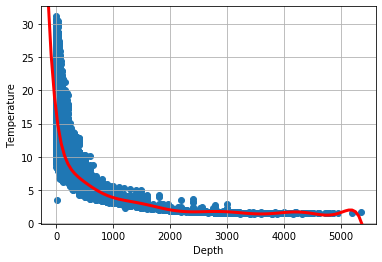

In [81]:
plot_model_on_data(X_val, y_val,"Depth", "Temperature", gs_pol)

In [82]:
print("Valutazione sul training:\n")
print_eval(X_train, y_train, gs_pol)
print("\n\nValutazione sul validation:\n")
print_eval(X_val, y_val, gs_pol)

Valutazione sul training:

   Mean squared error: 4.0499
       Relative error: 11.95282%
R-squared coefficient: 77.25145%


Valutazione sul validation:

   Mean squared error: 4.0401
       Relative error: 11.94163%
R-squared coefficient: 77.28689%


In [83]:
model_conf_interval(gs_pol, X_val, y_val)

(0.7712519753181286, 0.7744777996742971)

# Ridge

In [84]:
rid = Pipeline([
    ("poly",   PolynomialFeatures(degree=27, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", Ridge())
])
candidate_alphas = [1, 2,3,4,2.5,3.5]
grid = {"linreg__alpha": candidate_alphas}
gs_rid = GridSearchCV(rid, grid, cv=5)
gs_rid.fit(X_train, y_train)
gs_rid.best_params_

{'linreg__alpha': 1}

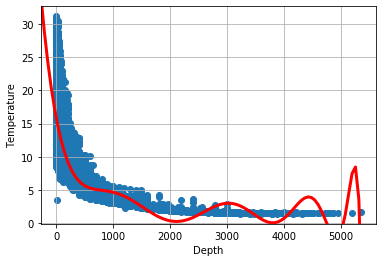

In [85]:
plot_model_on_data(X_val, y_val,"Depth", "Temperature", gs_rid)

In [86]:
print("Valutazione sul training:\n")
print_eval(X_train, y_train, gs_rid)
print("\n\nValutazione sul validation:\n")
print_eval(X_val, y_val, gs_rid)

Valutazione sul training:

   Mean squared error: 4.2402
       Relative error: 13.41103%
R-squared coefficient: 76.18255%


Valutazione sul validation:

   Mean squared error: 4.2348
       Relative error: 13.42443%
R-squared coefficient: 76.19223%


In [87]:
model_conf_interval(gs_rid, X_val, y_val)

(0.7602788553845455, 0.7635580263451677)

# Random forest

In [118]:
rf_reg = Pipeline([
    ('std', StandardScaler()),
    ('rfr', RandomForestRegressor())
])

grid = {
    'rfr__n_estimators': [10],
    'rfr__max_depth': [None, 1 ,2 ,3],
}

gs_rf = GridSearchCV(rf_reg, grid, cv=5)
gs_rf.fit(X_train, y_train)
gs_rf.best_params_


{'rfr__max_depth': None, 'rfr__n_estimators': 10}

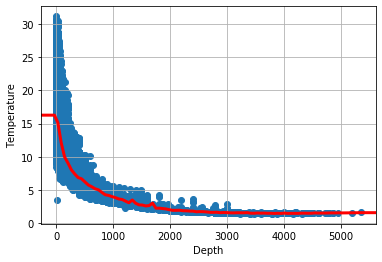

In [119]:
plot_model_on_data(X_val, y_val,"Depth", "Temperature", gs_rf)

In [120]:
print("Valutazione sul training:\n")
print_eval(X_train, y_train, gs_rf)
print("\n\nValutazione sul validation:\n")
print_eval(X_val, y_val, gs_rf)

Valutazione sul training:

   Mean squared error: 3.974
       Relative error: 11.74672%
R-squared coefficient: 77.67807%


Valutazione sul validation:

   Mean squared error: 3.971
       Relative error: 11.76941%
R-squared coefficient: 77.67492%


In [121]:
model_conf_interval(gs_rf, X_val, y_val)

(0.7751419993540449, 0.7783481690537235)

# Decision tree

In [114]:
dt_reg = Pipeline([
    ('std', StandardScaler()),
    ('dtr', DecisionTreeRegressor())
])

grid = {
    'dtr__max_depth': [None, 1 ,2 ,3],
}

gs_dt = GridSearchCV(dt_reg, grid, cv=5)
gs_dt.fit(X_train, y_train)
gs_dt.best_params_


{'dtr__max_depth': None,
 'dtr__min_samples_leaf': 3,
 'dtr__min_samples_split': 2,
 'std': StandardScaler(copy=True, with_mean=True, with_std=True)}

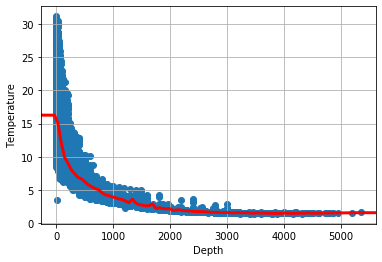

In [115]:
plot_model_on_data(X_val, y_val,"Depth", "Temperature", gs_dt)

In [116]:
print("Valutazione sul training:\n")
print_eval(X_train, y_train, gs_dt)
print("\n\nValutazione sul validation:\n")
print_eval(X_val, y_val, gs_dt)

Valutazione sul training:

   Mean squared error: 3.9738
       Relative error: 11.74797%
R-squared coefficient: 77.67897%


Valutazione sul validation:

   Mean squared error: 3.9707
       Relative error: 11.76817%
R-squared coefficient: 77.67689%


In [111]:
model_conf_interval(gs_dt, X_val, y_val)

(0.7751593883621977, 0.7783654693093216)

Random forest e Decision tree sono praticamente uguali quindi ho preso in considerazione solo il Random forest nell'ultima analisi

# Confronto fra modelli

In [92]:
def model_diff_interval(m1, m2, X, y, level=0.95):
    a1 = m1.score(X, y)
    a2 = m2.score(X, y)
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(a1, a2, N, N, Z)

# Random forest vs Linear

In [93]:
model_diff_interval(gs_rf, lin, X_val, y_val)

(0.31009557238829405, 0.31509790907139706)

# Random forest vs Polynomial 

In [94]:
model_diff_interval(gs_rf, gs_pol, X_val, y_val)

(0.0016017722753972293, 0.00614993510938403)

# Random forest vs Ridge

In [95]:
model_diff_interval(gs_rf, gs_rid, X_val, y_val)

(0.012529385201873633, 0.017115539894227427)

In nessun confronto abbiamo avuto un intervallo con lo 0 incluso quindi possiamo affermare che l'algoritmo Random Forest risulta il più accurato nel descrivere il rapporto fra profondità dell'acqua e la sua temperatura.

# Polynomial vs Linear

In [96]:
model_diff_interval(gs_pol, lin, X_val, y_val)

(0.3062134156872846, 0.31122835838762525)

# Polynomial vs Ridge

In [97]:
model_diff_interval(gs_pol, gs_rid, X_val, y_val)

(0.008646658157341534, 0.013246559553978268)

Il secondo algoritmo più preciso risulta essere quello Polinomiale.
Si può notare come anche se il Random Forest presenta una precisione di poco migliore non descrive bene le temperature nei primi 500 metri mentre nell'altro caso queste vengono seguite meglio dalla curva.